In [1]:
#                   VARIABLES GLOBALES
#
import numpy as np
import copy

L = 1       # Taille du domaine m
inter = 0.5 # posiiton de l'interface

gamma = 5 / 3

# Constantes dépendantes de gamma
z = (gamma - 1) / (2 * gamma) # g1 de Toro
g2 = (gamma + 1) / (2 * gamma)
g3 = 2 * gamma / (gamma - 1)
g4 = 2 / (gamma - 1)
g5 = 2 / (gamma + 1)
g6 = (gamma - 1) / (gamma + 1)
g7 = (gamma - 1) / 2
g8 = (gamma - 1)

## ----------------------------- Tube à choc ---------------------------- ##

# Variables initiales à gauche
rho0l = 1
u0l = 0
P0l = 1
c0l = np.sqrt(gamma * P0l / rho0l)
var_int0l = np.array([rho0l, u0l, P0l, c0l])

# Variables initiales à droite
rho0r = 0.125
u0r = 0
P0r = 0.1
c0r = np.sqrt(gamma * P0r / rho0r)
var_int0r = np.array([rho0r, u0r, P0r, c0r])

## ----------------------------- Solution exacte  ##

Ncell = 1_000 # Nombre de cellule
dx = L / Ncell # Pas spatial
mpa = 1 # Constante de normalisation

timeout = 0.2

x = np.zeros(Ncell)
for i in range(Ncell):
    x[i] = i * dx + (dx / 2)



In [2]:
#                   TUBE À CHOC
#               Problème de Riemann
#
# Solveur exact du Toro

import numpy as np


def CI(x, inter, tabl, tabr) :
    """Regroupe les conditions initiales des variables selon x, à t=0
    entrée :
    x : array : position
    inter : float : position de l'interface
    tabl : array : densité, vitesse, pression et vitesse du son à gauche de l'interface
    tabr : array : à droite de l'interface

    sortie :
    rho0 : array : densité à t=0
    u0 : array : vitesse à t=0
    P0 : array : pression à t=0
    """
    rhol, ul, Pl, cl = tabl
    rhor, ur, Pr, cr = tabr

    rho0 = np.zeros(len(x))
    u0 = np.zeros(len(x))
    P0 = np.zeros(len(x))

    for i in range(len(x)):
        if (x[i] <= inter): # Avant interface valeur côté gauche
            rho0[i] = rhol
            u0[i] = ul
            P0[i] = Pl
        else :  # Après interface valeur côté droit
            rho0[i] = rhor
            u0[i] = ur
            P0[i] = Pr
    return rho0, u0, P0

## ----------------------- Solveur exact --------------------------------- ##

def StarPU(mpa, tabl, tabr):
    """ Solution pour la pression et la vitesse dans la région star.
    entrée :
    mpa : int : facteur de normalisation
    tabl : array(4) : densité, vitesse, pression et vitesse du son à gauche de l'interface
    tabr : array(4) : à droite de l'interface

    sortie :
    P_star : float : pression dans la région star
    u_star : float : vitesse dans la région star
    """
    rhol, ul, Pl, cl = tabl
    rhor, ur, Pr, cr = tabr

    tolpre = 1e-6 # Seuil de variation
    niter = 20 # Nombre d'itération pour se rapprocher

    P_start = GuessP(tabl, tabr) # Pression initiale
    P_old = P_start # On la garde dans une variable
    u_diff = ur - ul

    for i in range(niter):
        fr, frd = Prefun(P_old, Pr, rhor, cr) # Données à droite
        fl, fld = Prefun(P_old, Pl, rhol, cl) # Données à gauche

        P_star = P_old - (fl + fr + u_diff) / (fld + frd)
        change =  2 * (P_star - P_old) / (P_star + P_old)
        #print(i, P_star, change)
        if (change < tolpre): # Comparaison dand l'évolution de la pression
            i = i + 1
        if (P_star < tolpre):
            P_old = P_star
            break
    u_star = 0.5 * (ul + ur + fr - fl)
    return u_star, P_star / mpa

def GuessP(tabl, tabr):
    """ 
    Définit une pression intelligente dans la star région, comme départ selon les paramètres initiaux
    entrée :
    tabl : array(4) : densité, vitesse, pression et vitesse du son à gauche de l'interface
    tabr : array(4) : à droite de l'interface

    sortie :
    P_star (float) : pression dans la région star
    """
    rhol, ul, Pl, cl = tabl
    rhor, ur, Pr, cr = tabr
    quser = 2 # ?

    #Pression donnée par le solveur de Riemann PVRS
    rho_star = (1 / 2) * (rhol + rhor) # Densité dans la star région
    c_star = (1 / 2) * (cl + cr) # Vitesse du son  dans la star région
    P_pvrs = (1 / 2) * (Pl + Pr) + (1 / 2) * (ul - ur) * rho_star * c_star # Pression PVRS
    P_pvrs  = np.max([0,P_pvrs]) # etre sur que la pression n'est pas négative
    Pmin = np.min([Pl, Pr])
    Pmax = np.max([Pl, Pr])
    qmax = Pmax / Pmin # Rapport des pressions

    if (qmax < quser) and ((Pmin <= P_pvrs) and (P_pvrs <= Pmax)): # Pression moyenne donnée par PVRS
        #print('Pression PVRS')
        P_star = P_pvrs
    else :
        if (P_pvrs < Pmin) : # Solveur TRRS
            #print('Pression TRRS')
            P_lr = (Pl / Pr)**z
            u_star = (P_lr * ul / cl + ur / cr + g4 * (P_lr - 1)) / (P_lr / cl + 1 / cr) # Vitesse moyenne
            Ptl = 1 + g7 * (ul - u_star) / cl
            Ptr =  1 + g7 * (u_star - ur) / cr
            P_star = (1 / 2) * (Pl * Ptr**(1 / z) + Pr * Ptr**(1 / z))

        else : # Solveur TSRS
            #print('Pression TSRS')
            gl = np.sqrt((g5 / rhol) / (P_pvrs + g6 * Pl))
            gr = np.sqrt((g5 / rhor) / (P_pvrs + g6 * Pr))
            P_star = (gl * Pl + gr * Pr - (ur - ul)) / (gl + gr)
    return P_star

def Prefun(P, Pk, rhok, ck):
    """Evalue les fonctions de pression Fl et Fr
    entrée :
    P (float) :  pression d'entrée estimée
    Pk (float) : pression côté L ou R
    rhok (float) :  densité côté L ou R
    ck (float) : vitesse du son côté L ou R

    sortie :
    fk (float) : fonction de la pression côté L ou R
    fd (float) : dérivée de la fonction de la pression côté L ou R
    """
    if (P < Pk) : # Onde de raréfaction
        P_rat = P / Pk # Ration
        fk = g4 * ck * (P_rat**z -1) # Fonction de pression fk(P)
        fd = (1 / (rhok * ck)) * P_rat**(- g2) # Dérivée
    else : # Onde de choc
        Ak = g5 / rhok
        Bk = g6 * Pk
        qrt = (np.sqrt(Ak / (P + Bk)))
        fk = (P - Pk) * qrt # Fonction de pression fk(P)
        fd =  (1 - 0.5 * (P - Pk) / (Bk + P)) * qrt # ???
    return fk, fd


def Sample(P_star, u_star, S, tabl, tabr):
    """Recherche de la solution à travers les différentes ondes
    entrée :
    P_star (float) : pression dans la région star
    U_star (float) : vitesse dans la région star
    S
    tabl : array(4) : densité, vitesse, pression et vitesse du son à gauche de l'interface
    tabr : array(4) : à droite de l'interface

    sortie :
    rho (float) : densité
    U (float) : vitesse
    P (float) : pression
    """
    rhol, ul, Pl, cl = tabl
    rhor, ur, Pr, cr = tabr

    if (S < u_star) : # A gauche de la discontinuité de contact
        if (P_star <= Pl) : # Onde de raréfaction à gauche
            Shl = ul - cl
            if (S <= Shl) : # Etat de gauche
                rho = rhol
                u = ul
                P = Pl
            else :
                cl_star = cl * (P_star / Pl)**(z)
                Stl = u_star - cl_star
                if (S > Stl): # Etat star gauche
                    rho = rhol * (P_star / Pl)**(1 / gamma)
                    u = u_star
                    P = P_star
                else : # Éventail de gauche
                    aide = g5 * (cl + g7 * (ul - S))
                    rho = rhol * (aide / cl)**g4
                    u = g5 * (cl + g7 * ul + S)
                    P = Pl * (aide / cl)**g3
        else : # Onde de choc à gauche
            rapl = P_star / Pl
            Sl = ul - cl * np.sqrt(g2 * rapl + z)
            if (S < Sl): # Etat de gauche
                rho = rhol
                u = ul
                P = Pl
            else : # Etat star gauche
                rho = rhol * (rapl + g6) / (rapl * g6 + 1)
                u = u_star
                P = P_star
    else : # A droite de la discontinuité de contact
        if (P_star > Pr) : # Onde de choc à droite
            rapr = P_star / Pr
            Sr = ur + cr * np.sqrt(g2 * rapr + z)
            if (S > Sr) :
                rho = rhor
                u = ur
                P = Pr
            else :
                rho = rhor * (rapr + g6) / (rapr * g6 + 1)
                u = u_star
                P = P_star
        else : # Onde de raréfaction à droite
            Shr = ur + cr
            if (S >= Shr): # État de droite
                rho = rhor
                u = ur
                P = Pr
            else :
                cr_star = cr * (P_star / Pr)**(z)
                Str = u_star + cr_star
                if (S <= Str) : # Etat star droite
                    rho = rhor * (P_star / Pr)**(1 / gamma)
                    u = u_star
                    P = P_star
                else : # Éventail de droite
                    aide2 = g5 * (cr - g7 * (ur - S))
                    rho = rhor * (aide2 / cr)**g4
                    u = g5 *(- cr + g7 * ur + S)
                    P = Pr * (aide2 / cr)**g3
    return rho, u, P

def SolveurExact(x, inter, var0L, var0R, t):
    """Méthode pour la solutoin exacte du prblème de Riemann
    entrée :
    x : array : position
    inter : float : position de l'interface
    var0L : array(4) : densité, vitesse, pression, vitesse du son initiales à gauche
    var0R : array(4) : valeurs à droite
    t : float : temps de sortie

    sortie :
    rho : array : densité
    u : array : vitesse
    P : array : pression
    e : array : énergie interne
    """
    rho = np.zeros(len(x))
    u = np.zeros(len(x))
    P = np.zeros(len(x))

    u_star, P_star = StarPU(1, var0L, var0R)
    for i in range(len(x)):
        S = (x[i] -  inter) / t # Vitesse selon la position
        rho[i], u[i], P[i] = Sample(P_star, u_star, S, var0L, var0R)

    #e = P / rho / g8
    e = P / (rho * g8)
    return rho, u , P, e


ok
-----------------------------
Calcul solution exacte tube à choc
Temps final tube à choc =  0.2


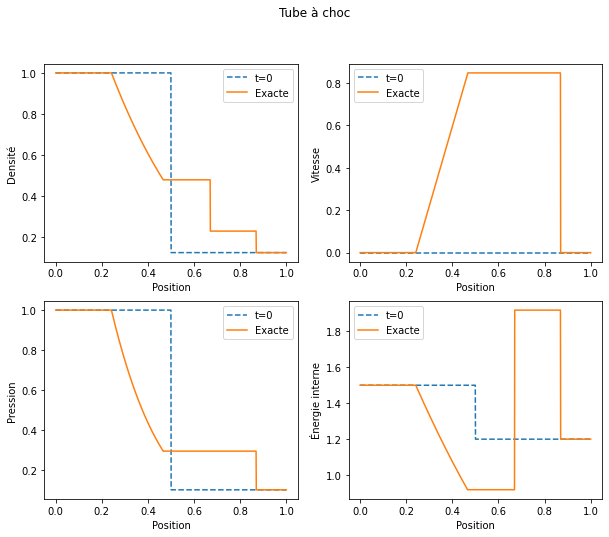

In [3]:
#                   TUBE À CHOC
#               Problème de Riemann
#
# Résolution des équations de l'hydrodynamique à 1d pour un tube à choc :
#           dt rho + dx (rho u) = 0
#           dt (rho u) + dx (rho u^{2} + P) = 0
#           dt E + dx (u(E + P)) = 0

# Solution exacte 1d extraite du Toro pout tube à choc

import numpy as np
import matplotlib.pyplot as plt




# Condition de positivité pour la pression
if (g4 * (c0l + c0r)) < (u0r - u0l) :
    print('Il faut inclure le vide')
else :
    print('ok')


## ----------------------------- Initialisation ----------------------------- ##
tab_rho0, tab_u0, tab_P0 = CI(x, inter, var_int0l, var_int0r)
tab_e0 = tab_P0 / tab_rho0 / g8

## ----------------------------- Solution exacte tube à choc ---------------- ##
print("-----------------------------")
print("Calcul solution exacte tube à choc")
tab_rhoExac, tab_uExac, tab_PExac, tab_eExac = SolveurExact(x, inter, var_int0l, var_int0r, timeout)
print('Temps final tube à choc = ', timeout)


## ----------------------------- Figures ------------------------------------ ##

plt.figure(figsize=(10,8))
plt.suptitle('Tube à choc')
plt.subplot(221)
plt.plot(x, tab_rho0, '--', label='t=0')
plt.plot(x, tab_rhoExac, label='Exacte')
plt.ylabel('Densité'); plt.xlabel('Position')
plt.legend()
plt.subplot(222)
plt.plot(x, tab_u0, '--', label='t=0')
plt.plot(x, tab_uExac, label='Exacte')
plt.ylabel('Vitesse'); plt.xlabel('Position')
plt.legend()
plt.subplot(223)
plt.plot(x, tab_P0,'--', label='t=0')
plt.plot(x, tab_PExac, label='Exacte')
plt.ylabel('Pression'); plt.xlabel('Position')
plt.legend()
plt.subplot(224)
plt.plot(x, tab_e0,'--', label='t=0')
plt.plot(x, tab_eExac, label='Exacte')
plt.ylabel('Énergie interne'); plt.xlabel('Position')
plt.legend()
plt.show()




In [4]:
def f(u1,u2,u3,gamma):  # fonction de flux
    f1 = u2
    f2 = u2*u2/u1+(u3-u2*u2/u1/2)*(gamma-1)
    f3 = u3*u2/u1+(u3-u2*u2/u1/2)*(gamma-1)*u2/u1
    return f1,f2,f3

In [5]:
def flux_Rusanov(rho,u,p,gamma,dx,timeout):
    t=0
    rhou = rho*u
    E = rhou*rhou/rho/2 + p/(gamma-1)
    while t<timeout:
        c = np.sqrt(gamma*p/rho)
        S = max(max(u+c),max(u-c))
        dt = dx/S/3                    # condition CFL
        dt = min(dt,timeout-t)
        f_rho,f_rhou,f_E = f(rho,rhou,E,gamma)   # flux
        for j in range(1,len(rho)-1):
            fG_rho = 1/2*(f_rho[j]+f_rho[j-1]) - S/2*(rho[j]-rho[j-1])
            fD_rho = 1/2*(f_rho[j+1]+f_rho[j]) - S/2*(rho[j+1]-rho[j])
            fG_rhou = 1/2*(f_rhou[j]+f_rhou[j-1]) - S/2*(rhou[j]-rhou[j-1])
            fD_rhou = 1/2*(f_rhou[j+1]+f_rhou[j]) - S/2*(rhou[j+1]-rhou[j])
            fG_E = 1/2*(f_E[j]+f_E[j-1]) - S/2*(E[j]-E[j-1])
            fD_E = 1/2*(f_E[j+1]+f_E[j]) - S/2*(E[j+1]-E[j])
        
            # mis a jour de la solutionn
            rho[j] = rho[j]-dt/dx*(fD_rho-fG_rho)
            rhou[j] = rhou[j] - dt/dx*(fD_rhou-fG_rhou)
            E[j] = E[j] - dt/dx*(fD_E-fG_E)
    
        u = rhou/rho
        p = (E-rhou*rhou/rho/2)*(gamma-1)  
        t += dt
    return rho,u,p

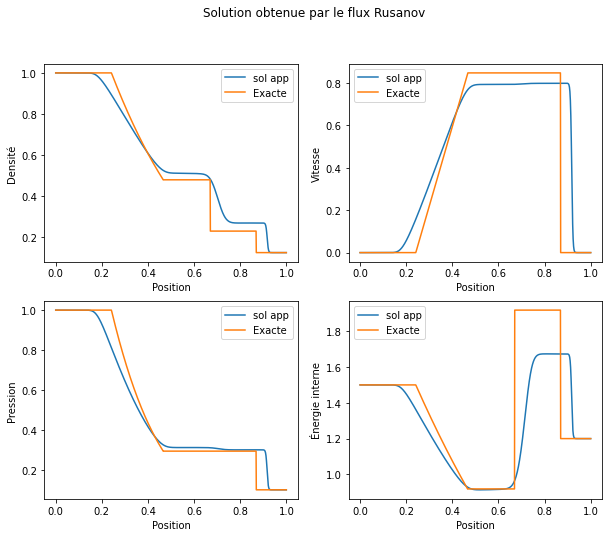

------------------------------------------------------------------
erreur de Densité :  1.9944666696189237
erreur de Vitesse :  5.685518057723765
erreur de Pression :  2.0630667154889384
erreur pour énergie interne :  7.478196052281819


In [6]:
rho, u, p = CI(x, inter, var_int0l, var_int0r)   # condition initiale
rho,u,p = flux_Rusanov(rho,u,p,gamma,dx,timeout)
plt.figure(figsize=(10,8))
plt.suptitle('Solution obtenue par le flux Rusanov')
plt.subplot(221)
plt.plot(x, rho, label='sol app')
plt.plot(x, tab_rhoExac, label='Exacte')
plt.ylabel('Densité'); plt.xlabel('Position')
plt.legend()
plt.subplot(222)
plt.plot(x, u, label='sol app')
plt.plot(x, tab_uExac, label='Exacte')
plt.ylabel('Vitesse'); plt.xlabel('Position')
plt.legend()
plt.subplot(223)
plt.plot(x,p , label='sol app')
plt.plot(x, tab_PExac, label='Exacte')
plt.ylabel('Pression'); plt.xlabel('Position')
plt.legend()
plt.subplot(224)
e = p / (rho* g8)
plt.plot(x, e, label='sol app')
plt.plot(x, tab_eExac, label='Exacte')
plt.ylabel('Énergie interne'); plt.xlabel('Position')
plt.legend()
plt.show()
print('------------------------------------------------------------------')

# calcul des erreurs
err_rho = np.linalg.norm(rho-tab_rhoExac)
err_u = np.linalg.norm(u-tab_uExac)
err_p = np.linalg.norm(p-tab_PExac)
err_e = np.linalg.norm(e-tab_eExac)
print('erreur de Densité : ', err_rho)
print('erreur de Vitesse : ', err_u)
print('erreur de Pression : ', err_p)
print('erreur pour énergie interne : ', err_e)

In [4]:
def hll_flux(rho_l, u_l, p_l, rho_r, u_r, p_r, gamma):

    # vitesse du son
    c_l = np.sqrt(gamma*p_l/rho_l)
    c_r = np.sqrt(gamma*p_r/rho_r)
    
    s_l = min(u_l - c_l, u_r - c_r, u_l + c_l, u_r + c_r)
    s_r = max(u_l - c_l, u_r - c_r, u_l + c_l, u_r + c_r)
    
    # fonction de flux
    fl_rho = u_l
    fr_rho = u_r
    fl_u = u_l**2/rho_l + (p_l-u_l**2/rho_l/2)*(gamma-1)
    fr_u = u_r**2/rho_r + (p_r-u_r**2/rho_r/2)*(gamma-1)
    fl_p = p_l*u_l/rho_l+(p_l-u_l*u_l/rho_l/2)*(gamma-1)*u_l/rho_l
    fr_p = p_r*u_r/rho_r+(p_r-u_r*u_r/rho_r/2)*(gamma-1)*u_r/rho_r
    
    
    # HLL flux
    if s_l >= 0:
        return fl_rho, fl_u, fl_p
    elif s_r <= 0:
        return fr_rho ,fr_u, fr_p
    else:
        f_rho = (s_r*fl_rho - s_l*fr_rho + s_l*s_r*(rho_r - rho_l)) / (s_r - s_l)
        f_u = (s_r*fl_u - s_l*fr_u + s_l*s_r*(u_r - u_l)) / (s_r - s_l)
        f_p = (s_r*fl_p - s_l*fr_p + s_l*s_r*(p_r - p_l)) / (s_r - s_l)
        return f_rho,f_u,f_p


def hll_solver(dx, rho0, u0, p0, gamma, tfinal):
    
    # condition initiale
    n = len(rho0)
    rho = 1*rho0
    u = 1*u0
    p = 1*p0
    rhou = rho*u
    E = rhou*rhou/rho/2 + p/(gamma-1)
    
    t = 0.0

    while t < tfinal:
        c = np.sqrt(gamma*p/rho)
        S = max(max(u+c),max(u-c))
        dt = dx/S/3                    # condition CFL
        
        # mis a jour de la solution et flux
        rho_f = np.zeros(n-1)
        u_f = np.zeros(n-1)
        p_f = np.zeros(n-1)
        for i in range(n-1):
            rho_f[i], u_f[i], p_f[i] = hll_flux(rho[i], rhou[i], E[i], rho[i+1], rhou[i+1], E[i+1], gamma)
        for i in range(1,n-1):
            rho[i] -= dt/dx*(rho_f[i] - rho_f[i-1])
            rhou[i] -= dt/dx*(u_f[i] - u_f[i-1])
            E[i] -= dt/dx*(p_f[i] - p_f[i-1])
            
        u = rhou/rho
        p = (E-rhou*rhou/rho/2)*(gamma-1)  
        t += dt
    return rho,u,p


In [8]:
rho1,u1,p1 = hll_solver(dx,tab_rho0,tab_u0,tab_P0,gamma,timeout)

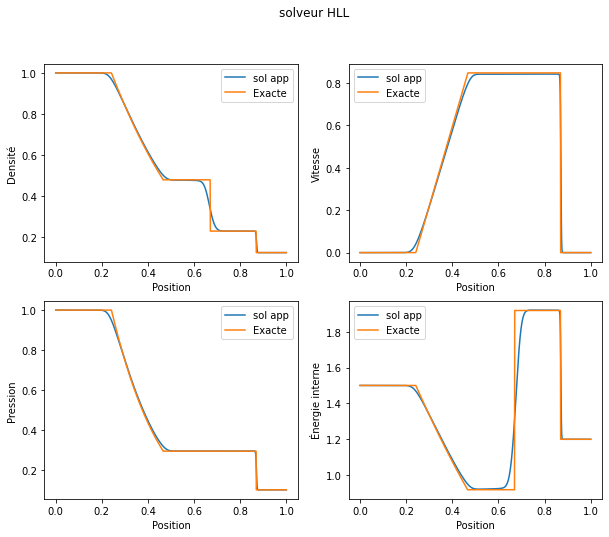

------------------------------------------------------------------
erreur de Densité :  0.5811498880717852
erreur de Vitesse :  0.8904445350805411
erreur de Pression :  0.31636161694074183
erreur pour énergie interne :  2.32314910833552


In [9]:
plt.figure(figsize=(10,8))
plt.suptitle('solveur HLL')
plt.subplot(221)
plt.plot(x, rho1, label='sol app')
plt.plot(x, tab_rhoExac, label='Exacte')
plt.ylabel('Densité'); plt.xlabel('Position')
plt.legend()
plt.subplot(222)
plt.plot(x, u1, label='sol app')
plt.plot(x, tab_uExac, label='Exacte')
plt.ylabel('Vitesse'); plt.xlabel('Position')
plt.legend()
plt.subplot(223)
plt.plot(x,p1 , label='sol app')
plt.plot(x, tab_PExac, label='Exacte')
plt.ylabel('Pression'); plt.xlabel('Position')
plt.legend()
plt.subplot(224)
e1 = p1 / (rho1* g8)
plt.plot(x, e1, label='sol app')
plt.plot(x, tab_eExac, label='Exacte')
plt.ylabel('Énergie interne'); plt.xlabel('Position')
plt.legend()
plt.show()
print('------------------------------------------------------------------')

# calcul des erreurs
err_rho1 = np.linalg.norm(rho1-tab_rhoExac)
err_u1 = np.linalg.norm(u1-tab_uExac)
err_p1 = np.linalg.norm(p1-tab_PExac)
err_e1 = np.linalg.norm(e1-tab_eExac)
print('erreur de Densité : ', err_rho1)
print('erreur de Vitesse : ', err_u1)
print('erreur de Pression : ', err_p1)
print('erreur pour énergie interne : ', err_e1)

### Nouvelle condition initiale
$$\rho_0 = 2 + \sin(2\pi x)$$
$$u_0 = 1$$
$$p_0 = 1$$

In [5]:
# condition initiale
def CI2(Ncell,x):
    rho0 = np.zeros(Ncell)
    u0 = np.ones(Ncell)
    p0 = np.ones(Ncell)
    for i in range(Ncell):
        rho0[i] = 2+np.sin(x[i]*2*np.pi)
    return rho0,u0,p0

In [82]:
def flux_Rusanov_per(rho,u,p,gamma,dx,timeout):
    t=0
    rhou = rho*u
    E = rhou*rhou/rho/2 + p/(gamma-1)
    while t<timeout:
        c = np.sqrt(gamma*p/rho)
        S = max(max(u+c),max(u-c))
        dt = dx/S/3                    # condition CFL
        dt = min(dt,timeout-t)
        f_rho,f_rhou,f_E = f(rho,rhou,E,gamma)   # flux
        for j in range(0,len(rho)):
            if j==0:
                fG_rho = 1/2*(f_rho[j]+f_rho[-2]) - S/2*(rho[j]-rho[-2])
                fD_rho = 1/2*(f_rho[j+1]+f_rho[j]) - S/2*(rho[j+1]-rho[j])
                fG_rhou = 1/2*(f_rhou[j]+f_rhou[-2]) - S/2*(rhou[j]-rhou[-2])
                fD_rhou = 1/2*(f_rhou[j+1]+f_rhou[j]) - S/2*(rhou[j+1]-rhou[j])
                fG_E = 1/2*(f_E[j]+f_E[-2]) - S/2*(E[j]-E[-2])
                fD_E = 1/2*(f_E[j+1]+f_E[j]) - S/2*(E[j+1]-E[j])
            elif j == len(rho)-1:
                fG_rho = 1/2*(f_rho[j]+f_rho[j-1]) - S/2*(rho[j]-rho[j-1])
                fD_rho = 1/2*(f_rho[1]+f_rho[j]) - S/2*(rho[1]-rho[j])
                fG_rhou = 1/2*(f_rhou[j]+f_rhou[j-1]) - S/2*(rhou[j]-rhou[j-1])
                fD_rhou = 1/2*(f_rhou[1]+f_rhou[j]) - S/2*(rhou[1]-rhou[j])
                fG_E = 1/2*(f_E[j]+f_E[j-1]) - S/2*(E[j]-E[j-1])
                fD_E = 1/2*(f_E[1]+f_E[j]) - S/2*(E[1]-E[j])
            else:
                fG_rho = 1/2*(f_rho[j]+f_rho[j-1]) - S/2*(rho[j]-rho[j-1])
                fD_rho = 1/2*(f_rho[j+1]+f_rho[j]) - S/2*(rho[j+1]-rho[j])
                fG_rhou = 1/2*(f_rhou[j]+f_rhou[j-1]) - S/2*(rhou[j]-rhou[j-1])
                fD_rhou = 1/2*(f_rhou[j+1]+f_rhou[j]) - S/2*(rhou[j+1]-rhou[j])
                fG_E = 1/2*(f_E[j]+f_E[j-1]) - S/2*(E[j]-E[j-1])
                fD_E = 1/2*(f_E[j+1]+f_E[j]) - S/2*(E[j+1]-E[j])
        
            # mis a jour de la solutionn
            rho[j] = rho[j]-dt/dx*(fD_rho-fG_rho)
            rhou[j] = rhou[j] - dt/dx*(fD_rhou-fG_rhou)
            E[j] = E[j] - dt/dx*(fD_E-fG_E)
    
        u = rhou/rho
        p = (E-rhou*rhou/rho/2)*(gamma-1)  
        t += dt
    return rho,u,p

In [5]:
rho0,u0,p0 = CI2(Ncell,x)
rho2,u2,p2 = flux_Rusanov_per(rho0,u0,p0,gamma,dx,0.3)

NameError: name 'flux_Rusanov_per' is not defined

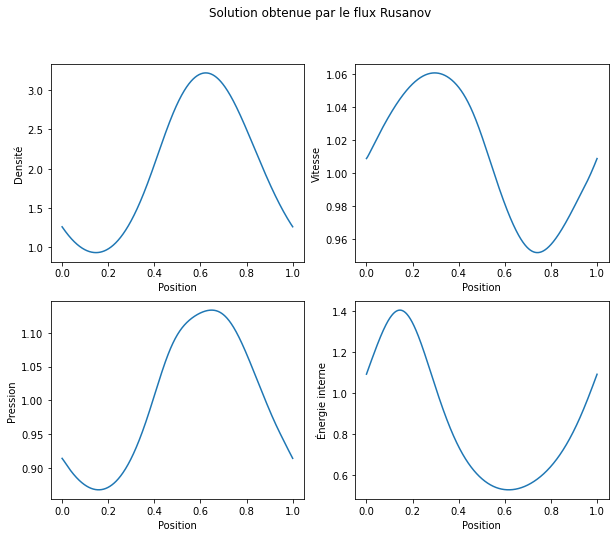

In [84]:
plt.figure(figsize=(10,8))
plt.suptitle('Solution obtenue par le flux Rusanov')
plt.subplot(221)
plt.plot(x, rho2)
plt.ylabel('Densité'); plt.xlabel('Position')
#plt.legend()
plt.subplot(222)
plt.plot(x, u2)
plt.ylabel('Vitesse'); plt.xlabel('Position')
#plt.legend()
plt.subplot(223)
plt.plot(x,p2)
plt.ylabel('Pression'); plt.xlabel('Position')
#plt.legend()
plt.subplot(224)
e2 = p2 / (rho2* g8)
plt.plot(x, e2)
plt.ylabel('Énergie interne'); plt.xlabel('Position')
#plt.legend()
plt.show()

In [6]:
def hll_solver_per(dx, rho0, u0, p0, gamma, tfinal):   # condition periodique
    
    # condition initiale
    n = len(rho0)
    rho = 1*rho0
    u = 1*u0
    p = 1*p0
    rhou = rho*u
    E = rhou*rhou/rho/2 + p/(gamma-1)
    
    t = 0.0

    while t < tfinal:
        c = np.sqrt(gamma*p/rho)
        S = max(max(u+c),max(u-c))
        dt = dx/S/3                   # condition CFL
        
        # mis a jour de la solution et flux
        rho_f = np.zeros(n-1)
        u_f = np.zeros(n-1)
        p_f = np.zeros(n-1)
        for i in range(n-1):
            rho_f[i], u_f[i], p_f[i] = hll_flux(rho[i], rhou[i], E[i], rho[i+1], rhou[i+1], E[i+1], gamma)
        for i in range(n):
            if i==0:
                rho[i] -= dt/dx*(rho_f[i] - rho_f[-2])
                rhou[i] -= dt/dx*(u_f[i] - u_f[-2])
                E[i] -= dt/dx*(p_f[i] - p_f[-2])
            elif i==n-1:
                rho[i] -= dt/dx*(rho_f[1] - rho_f[i-1])
                rhou[i] -= dt/dx*(u_f[1] - u_f[i-1])
                E[i] -= dt/dx*(p_f[1] - p_f[i-1])
            else:
                rho[i] -= dt/dx*(rho_f[i] - rho_f[i-1])
                rhou[i] -= dt/dx*(u_f[i] - u_f[i-1])
                E[i] -= dt/dx*(p_f[i] - p_f[i-1])
            
        u = rhou/rho
        p = (E-rhou*rhou/rho/2)*(gamma-1)  
        t += dt
    return rho,u,p


In [7]:
rho0,u0,p0 = CI2(Ncell,x)
rho3,u3,p3 = hll_solver_per(dx, rho0, u0, p0, gamma, 0.3)

NameError: name 'hll_flux' is not defined

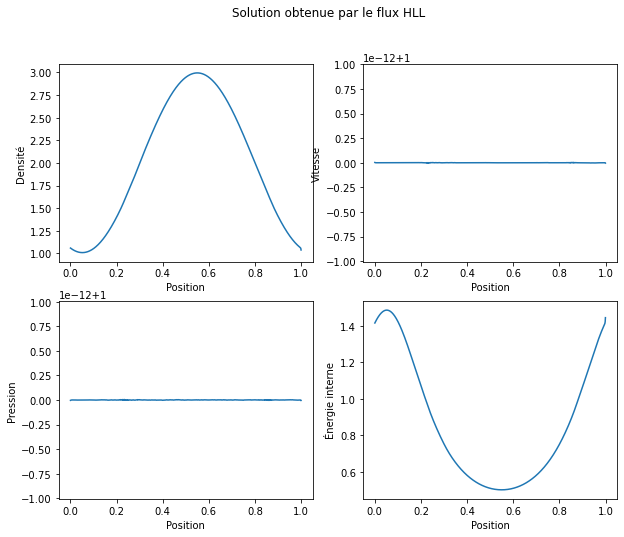

In [89]:
plt.figure(figsize=(10,8))
plt.suptitle('Solution obtenue par le flux HLL')
plt.subplot(221)
plt.plot(x, rho3)
plt.ylabel('Densité'); plt.xlabel('Position')
#plt.legend()
plt.subplot(222)
plt.plot(x, u3)
plt.ylabel('Vitesse'); plt.xlabel('Position')
#plt.legend()
plt.subplot(223)
plt.plot(x,p3)
plt.ylabel('Pression'); plt.xlabel('Position')
#plt.legend()
plt.subplot(224)
e3 = p3 / (rho3* g8)
plt.plot(x, e3)
plt.ylabel('Énergie interne'); plt.xlabel('Position')
#plt.legend()
plt.show()

### Animation

In [6]:
def hll_solver_per_anim(dx, rho0, u0, p0, gamma, t,tfinal):   # condition periodique
    
    # condition initiale
    n = len(rho0)
    rho = 1*rho0
    u = 1*u0
    p = 1*p0
    rhou = rho*u
    E = rhou*rhou/rho/2 + p/(gamma-1)

    while t < tfinal:
        c = np.sqrt(gamma*p/rho)
        S = max(max(u+c),max(u-c))
        dt = dx/S/3                    # condition CFL
        
        # mis a jour de la solution et flux
        rho_f = np.zeros(n-1)
        u_f = np.zeros(n-1)
        p_f = np.zeros(n-1)
        for i in range(n-1):
            rho_f[i], u_f[i], p_f[i] = hll_flux(rho[i], rhou[i], E[i], rho[i+1], rhou[i+1], E[i+1], gamma)
        for i in range(n):
            if i==0:
                rho[i] -= dt/dx*(rho_f[i] - rho_f[-1])
                rhou[i] -= dt/dx*(u_f[i] - u_f[-1])
                E[i] -= dt/dx*(p_f[i] - p_f[-1])
            elif i==n-1:
                rho[i] -= dt/dx*(rho_f[0] - rho_f[i-1])
                rhou[i] -= dt/dx*(u_f[0] - u_f[i-1])
                E[i] -= dt/dx*(p_f[0] - p_f[i-1])
            else:
                rho[i] -= dt/dx*(rho_f[i] - rho_f[i-1])
                rhou[i] -= dt/dx*(u_f[i] - u_f[i-1])
                E[i] -= dt/dx*(p_f[i] - p_f[i-1])
            
        u = rhou/rho
        p = (E-rhou*rhou/rho/2)*(gamma-1)  
        t += dt
        break
    return rho,u,p,t


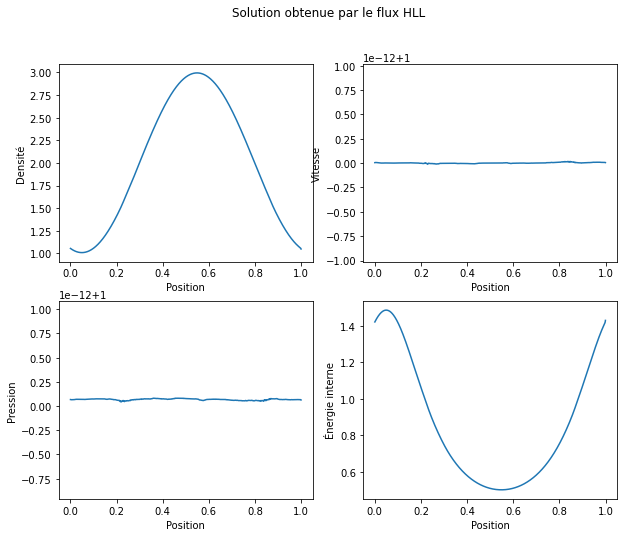

In [8]:
from IPython import display
T = 0.3
t = 0
rho0,u0,p0 = CI2(Ncell,x)
rho4,u4,p4,t = hll_solver_per_anim(dx, rho0, u0, p0, gamma, t, T)
i = 0
while t<T:
    i+=1
    rho4,u4,p4,t = hll_solver_per_anim(dx, rho4, u4, p4, gamma, t, T)
    if i%50 == 0:
        plt.figure(figsize=(10,8))
        plt.suptitle('Solution obtenue par le flux HLL')
        plt.subplot(221)
        plt.plot(x, rho4)
        plt.ylabel('Densité'); plt.xlabel('Position')

        plt.subplot(222)
        plt.plot(x, u4)
        plt.ylabel('Vitesse'); plt.xlabel('Position')

        plt.subplot(223)
        plt.plot(x,p4)
        plt.ylabel('Pression'); plt.xlabel('Position')

        plt.subplot(224)
        e4 = p4 / (rho4* g8)
        plt.plot(x, e4)
        plt.ylabel('Énergie interne'); plt.xlabel('Position')
        plt.show()
        
        display.clear_output(wait = True)
        plt.pause(0.0001)